This notebook validates the Nufft code from three aspects:
1. The non-uniform data we get from Nufft operator, is very similar to the kspace date we generate from system matrix;
2. The derivative of Nufft operator is computed correctly;
3. Batch works.


## 0 Loading libraries and data

For first two step (validation of Nufft approximation and derivative) I use 2D image with size (48, 48) due to computation ability limit.

In [1]:
import os
from tfNufft import tfNUFFT
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import cv2

In [2]:
folder_path = r'./data'
traj = np.load(os.path.join(folder_path, '2dspiral.npy'))
image = np.load(os.path.join(folder_path, '2dobj.npy'))
image = image[::10,::5] # even size
# image = image[100:127, 100:127] # odd size

In [3]:
om = traj.copy()
om[:,0] = traj[:,1]
om[:,1] = traj[:,0]

om = om / om.max() * 3  # normalized between (-pi,pi)

Text(0.5, 1.0, 'spiral trajectory')

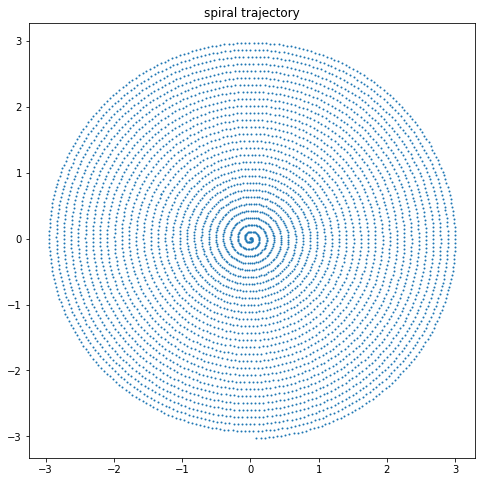

In [4]:
plt.figure(figsize=(8,8))
plt.scatter(om[:,0], om[:,1],s=1)
plt.title('spiral trajectory')

## 1 Validation of derivative

1. show that tensor auto-grad is working;
2. show that the tensor gradient is close to numeric derivative.

Notice, tfNufftObj.test_derivative(x) is using dense matrix but not tf.sparse.SparseTensor. 

In [5]:
batch = 1
batch_image = np.expand_dims(image, axis=0)
batch_image = np.tile(batch_image, [batch,1,1])

Nd = image.shape # image size
Kd = Nd # fft size
Jd = (3,3) #kernel size

In [6]:
tfNufftObj = tfNUFFT()
tfNufftObj.plan(om, Nd, Kd, Jd) #
tfNufftObj.batch = batch_image.shape[0]
tfNufftObj.preapre_for_tf() #convert array to tensor

In [7]:
b = np.random.rand(len(om),batch)+1j*np.random.rand(len(om),batch)
b = tf.cast(b, tfNufftObj.dtype)

Auto-grad using tensor.

In [8]:
x = tf.cast(batch_image, tf.float32)
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.reduce_sum(tf.abs(tfNufftObj.test_derivative(x)-b)**2)
    
tf_dx = t.gradient(y, x) #Auto-grad using tensor.

Numerically approximate the derivative: numeric_dx = (f(x+d) - f(x-d))/(2d).

And here I use `dif` the sum up the relative residual error of auto-grad and numeric derivative.

Relative residual error is calculated as abs(numeric_dx-tf_dx)/abs(tf_dx).

In [9]:
indices = [[None for _ in range(len(batch_image.shape))] for _ in range(Nd[0]*Nd[1])]
grid = np.meshgrid(batch-1,range(0,Nd[0]),range(0,Nd[1])) #indices for the whole image
m = 0
for i,j,k in zip(grid[0].ravel(),grid[1].ravel(),grid[2].ravel()):
    indices[m] = [i,j,k]
    m += 1
    
randomind = np.random.choice(len(indices),50,replace=False) #randomly select 100 points for validation

In [10]:
d = 1e-1
x = batch_image.copy()
numeric_dx = np.zeros_like(x)
mask = np.zeros_like(x)

for ind in randomind:
    i,j,k = indices[ind]
    n = np.zeros_like(x)
    n[i][j][k] = 1
    mask += n

    y1 = tf.reduce_sum(tf.abs(tfNufftObj.forward(x-n*d)-b)**2)
    y2 = tf.reduce_sum(tf.abs(tfNufftObj.forward(x+n*d)-b)**2)
    numeric_dx[i][j][k] = (y2-y1)/2/d

In [11]:
rre_dx = np.linalg.norm(np.ravel(mask*tf_dx - numeric_dx)) / np.linalg.norm(np.ravel(numeric_dx))
print('Rel err between tf dx and numeric dx is: %.5f'%rre_dx)

Rel err between tf dx and numeric dx is: 0.00037


## 2 Validation of Nufft

In [12]:
folder_path = r'./data'
traj = np.load(os.path.join(folder_path, '2dspiral.npy'))
image = np.load(os.path.join(folder_path, '2dobj.npy'))
image = image[100:152, 100:126] # even size
# image = image[100:127, 100:127] # odd size

om = traj.copy()
om[:,0] = traj[:,1]
om[:,1] = traj[:,0]
om = om / om.max() * 3

batch = 1
batch_image = np.expand_dims(image, axis=0)
batch_image = np.tile(batch_image, [batch,1,1])

Nd = image.shape # image size
Kd = (Nd[0] * 2, Nd[0] * 2) # fft size
Jd = (7,7) #kernel size
print('Image size is: ',Nd)

Image size is:  (52, 26)


In [13]:
def create_dft_op(imsz, traj):
    [xq, yq] = np.meshgrid( (np.arange(0, imsz[0]) - imsz[0]//2)/imsz[0], \
                            (np.arange(0, imsz[1]) - imsz[1]//2)/imsz[1], indexing = 'ij' )
    grid = np.concatenate([np.reshape(xq,(-1,1)), np.reshape(yq,(-1,1))], axis = 1)
    operator = np.matmul(traj, grid.T)
    return np.exp(-1j*operator)

Eop = create_dft_op(Nd, om * Nd)

E_k = Eop @ np.reshape(image, [-1, 1])
E_k = tf.cast(E_k.T, tf.complex64)

tfNufftObj = tfNUFFT()
tfNufftObj.plan(om, Nd, Kd, Jd) #
tfNufftObj.batch = batch_image.shape[0]
tfNufftObj.preapre_for_tf()
Nufft_k = tfNufftObj.forward(batch_image)

In [14]:
print(Nufft_k.shape)

(1, 4783)


Rel err Eop vs nufft 1.4804181e-06


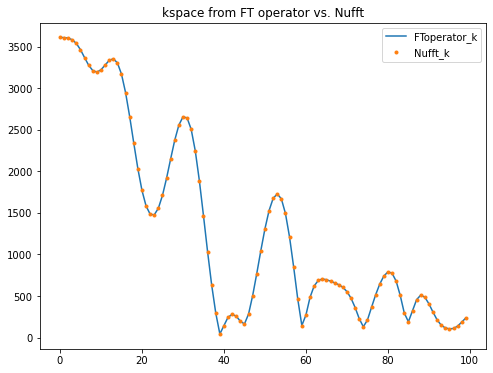

In [15]:
rre = np.linalg.norm(np.ravel(E_k-Nufft_k)) / np.linalg.norm(np.ravel(E_k))
plt.figure(figsize=(8,6))
plt.plot(np.abs(E_k)[0,:100], label='FToperator_k')
plt.plot(np.abs(Nufft_k)[0,:100], '.', label='Nufft_k')
plt.legend()
plt.title('kspace from FT operator vs. Nufft')
print('Rel err Eop vs nufft', rre)

Also, we can test if the Nufft operator calculated from Nufft_ksp works on E_k.

In [16]:
tfNufftObj = tfNUFFT()
tfNufftObj.plan(om, Nd, Kd, Jd)
tfNufftObj.preapre_for_tf()
tfNufftObj.batch = batch_image.shape[0]
Nufft_k = tfNufftObj.forward(batch_image)
Nufft_adj = tfNufftObj.adjoint(Nufft_k)
E_adj = tfNufftObj.adjoint(E_k)

Text(0.5, 1.0, 'adj image from Nufft_k')

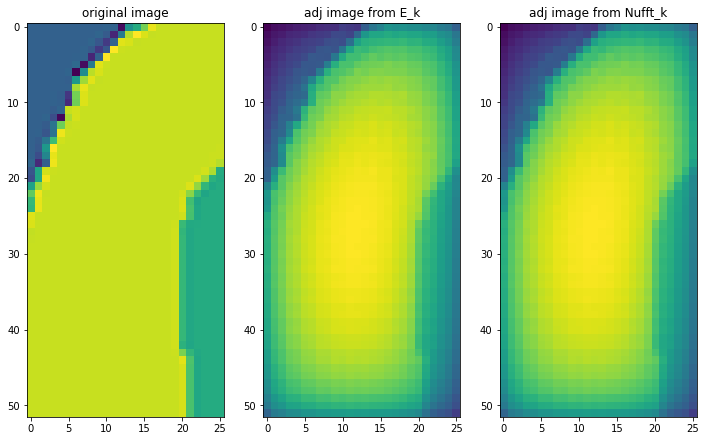

In [17]:
fig,ax = plt.subplots(1,3,figsize=(12,8))

ax[0].imshow(batch_image[0])
ax[0].set_title('original image')
ax[1].imshow(abs(E_adj[0]))
ax[1].set_title('adj image from E_k')
ax[2].imshow(abs(Nufft_adj[0]))
ax[2].set_title('adj image from Nufft_k')

Text(0.5, 1.0, 'adj image from Nufft_k')

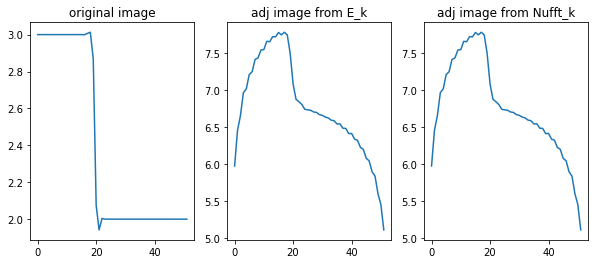

In [18]:
slices = 24

fig,ax = plt.subplots(1,3,figsize=(10,4))

ax[0].plot(batch_image[0,:,slices])
ax[0].set_title('original image')
ax[1].plot(abs(E_adj[0,:,slices]))
ax[1].set_title('adj image from E_k')
ax[2].plot(abs(Nufft_adj[0,:,slices]))
ax[2].set_title('adj image from Nufft_k')

## 3 Validation of batches


Here I repeat the same 2D image for batch times.

In [24]:
batch = 4
batch_image = np.expand_dims(image, axis=0)
batch_image = np.tile(batch_image, [batch,1,1])

Nd = image.shape # image size
Kd = (Nd[0] * 2, Nd[1] * 2) # fft size
Jd = (7,7) #kernel size

In [25]:
print(Nd)

(52, 26)


In [26]:
tfNufftObj = tfNUFFT()
tfNufftObj.plan(om, Nd, Kd, Jd)
tfNufftObj.preapre_for_tf()
tfNufftObj.batch = batch_image.shape[0]
kspace = tfNufftObj.forward(batch_image)
Nufft_adj = tfNufftObj.adjoint(kspace)

In [27]:
print(kspace.shape)

(4, 4783)


To validate that the batch works, I try to show that the adjoint image at every slice is the same.

In [28]:
for i in range(1,batch):
    print(np.sum(Nufft_adj[0]-Nufft_adj[i]))

0j
0j
0j


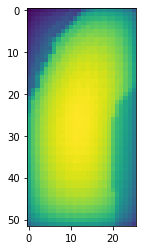

In [29]:
plt.imshow(abs(Nufft_adj[0]))

Validation using 3D images.


In [30]:
DATA_PATH = './data/'
image3D = np.load(DATA_PATH + 'phantom_3D_128_128_128.npz')['arr_0']

image3D = cv2.resize(image3D,(48,48))
image3D = image3D[:,:,::4]

batch = 4
batch_image3D = np.expand_dims(image3D, axis=0)
batch_image3D = np.tile(batch_image3D, [batch,1,1,1])

traj3D = np.load(os.path.join(DATA_PATH, '3dspiral.npy'))
new_traj3D = np.zeros_like(traj3D)
new_traj3D[:,0] = traj3D[:,1]
new_traj3D[:,1] = traj3D[:,0]
new_traj3D[:,2] = traj3D[:,2]
om3D = new_traj3D
om3D = om3D / om3D.max() * 3  # normalized between (-pi,pi)

In [36]:
Nd = image3D.shape # image size
Kd = Nd # fft size
Jd = (3,3,3) #kernel size

In [37]:
tfNufftObj = tfNUFFT()
tfNufftObj.plan(om3D, Nd, Kd, Jd)
tfNufftObj.preapre_for_tf()
tfNufftObj.batch = batch_image.shape[0]
kspace3D = tfNufftObj.forward(batch_image3D)
Nufft_adj3D = tfNufftObj.adjoint(kspace3D)

In [38]:
print(batch_image3D.shape)

(4, 48, 48, 32)


In [39]:
for i in range(1,batch):
    print(np.sum(Nufft_adj3D[0]-Nufft_adj3D[i]))

0j
0j
0j


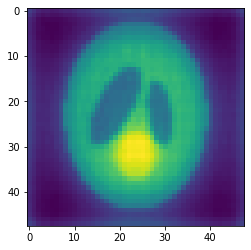

In [40]:
plt.imshow(abs(Nufft_adj3D[0,:,:,16]))